# AI534 Implementation Assignment 4

**Deadline**: 12/08/23 11:59PM

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

This assignment comprises two parts. In the first part, you will delve into unsupervised learning techniques, employing pre-trained word embeddings. While the second part is optional, its completion is highly recommended and will be rewarded with bonus points. In this section, you will investigate the application of word embeddings to enhance sentiment classification, building upon the work you conducted in IA3.

We have supplied auxiliary code for working with word embeddings. It is advisable to retain this code in its original form. Should you opt to modify this helper code, please ensure that your alterations are accompanied by comprehensive comments. This will facilitate your TA's understanding of the modifications and the rationale behind them.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# add more imports if necessary

# Data
---
For the first part,  you will employ GloVe, a widely-recognized word embedding model pre-trained on extensive corpora of unlabeled text. Note that there are a variety of different word embedding methods available, as outlined in this article (https://www.turing.com/kb/guide-on-word-embeddings-in-nlp). For this assignment, we will focus on GloVe embeddings (https://nlp.stanford.edu/projects/glove/). Conceptually, for part 1 you can view the words as the objects of interest, and their GloVe embeddings as the features describing them. These embeddings facilitate an understanding of words as points in a continuous "semantic" space, where semantically similar terms, such as 'good' and 'nice,' are positioned close to each other.


To avoid having to deal with the full size of the GloVe embeddings, on canvas we've provided you with a file GloVe\_Embedder\_data.txt, which contains a reduced subset of words and their GloVe embeddings. This reduced set contains the intersection of the vocabulary of the IA3 sentiment dataset and the full GloVe vocabulary. Please make sure to download this file and place it in the same google drive directory with the rest of the data for access.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
EMBEDDING_PATH = '/content/gdrive/My Drive/AI534/GloVe_Embedder_data.txt' #please do not modify this path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Helper class and functions --- Please leave as is.
# If you need to modify this block, please clearly indicate your change by providing detailed comments.
#
# Loads GloVe embeddings from a designated file location.
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find k nearest neighbors of word via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7

    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    #
    # If indicate_unk is set to True, the return type will be a tuple of
    # (numpy array, bool) with the bool indicating whether the returned
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)

    # Finds the vocab words associated with the k nearest embeddings of the provided word.
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

# Part 1: Explore word embeddings (80 pts)



## 1.1. Build your own data set of words. ( 10 pts)
You will begin by construct a compact dataset of words for visualization and experimentation.
Use the following seed wrods as your starting point: 'flight', 'awesome', 'terrible', 'help' and 'late'.
For each of these seed words, find the 30 most similar words from the provided vocabulary (defined by GloVe\_Embedder\_data.txt). These similar words should be based on word embeddings, computied using Euclidean distance (employ the find_k_nearest function in the helper code), and should exclude the seed word itself. Collect and record these words along with their embeddings. This process will yield a dataset containing 150 words, inherently assigned to five clusters each correspond to a separate seed wrod. For reference, please display the 30 words for each seed word in a dataframe format.

In [ ]:
# Your code goes here
glove      = GloVe_Embedder(EMBEDDING_PATH)
seed_words = ['flight', 'awesome', 'terrible', 'help', 'late']

NUM_SIMILAR_WORDS = 30                                   # Number of similar words to search in the vocabulary
collected_data    = {'words':{}, 'embeddings':{}}        # Dictionary to collect words

# Loop through seed words to collect 30 similar words from the vocabulary
for seed_word in seed_words:
  nearest_words                             = glove.find_k_nearest(seed_word, NUM_SIMILAR_WORDS + 1)
  words_embed                               = [[i[0], glove.embedding_dict[i[0]]] for i in nearest_words[1:]] # Extracting words only and finding their embeddings
  collected_data['words'][seed_word]        = [i[0] for i in words_embed]     # Store words only
  collected_data['embeddings'][seed_word]   = [i[1] for i in words_embed]     # Store embeddings only

# Displaying the 30 words collected

df = pd.DataFrame.from_dict(collected_data['words'])
df

,flight,awesome,terrible,help,late
0,plane,amazing,horrible,need,early
1,flights,great,awful,helping,earlier
2,boarding,fantastic,bad,please,usual
3,airline,cool,brutal,pls,after
4,jet,fun,idea,let,again
5,flying,epic,horrendous,us,saturday
6,heading,wonderful,horrid,give,afternoon
7,arrival,definitely,shitty,trying,hour
8,airlines,seriously,quite,can,guess
9,travel,totally,worst,helps,missed


## 1.2. Let's visualization the data. (35 pts)


### 1.2.1. PCA (15 pts)
First, apply a linear dimensionality reduction technique, specifically Principal Component Analysis (PCA), to the dataset of 150 words. Utilize the PCA function from sklearn.decomposition for this purpose. Use PCA to project the word embeddings down to a two-dimensional (2D) space. Subsequently, visualize these 2D embeddings using a scatter plot. Employ the scatter function from matplotlib for creating the plot.


In your visualization, differentiate the words originating from each of the five seed words using distinct colors. Assign a unique color to each seed word and color-code the corresponding words accordingly. Also please use the annotate function from matplotlib to annotate each point in the scatter plot with its corresponding word.



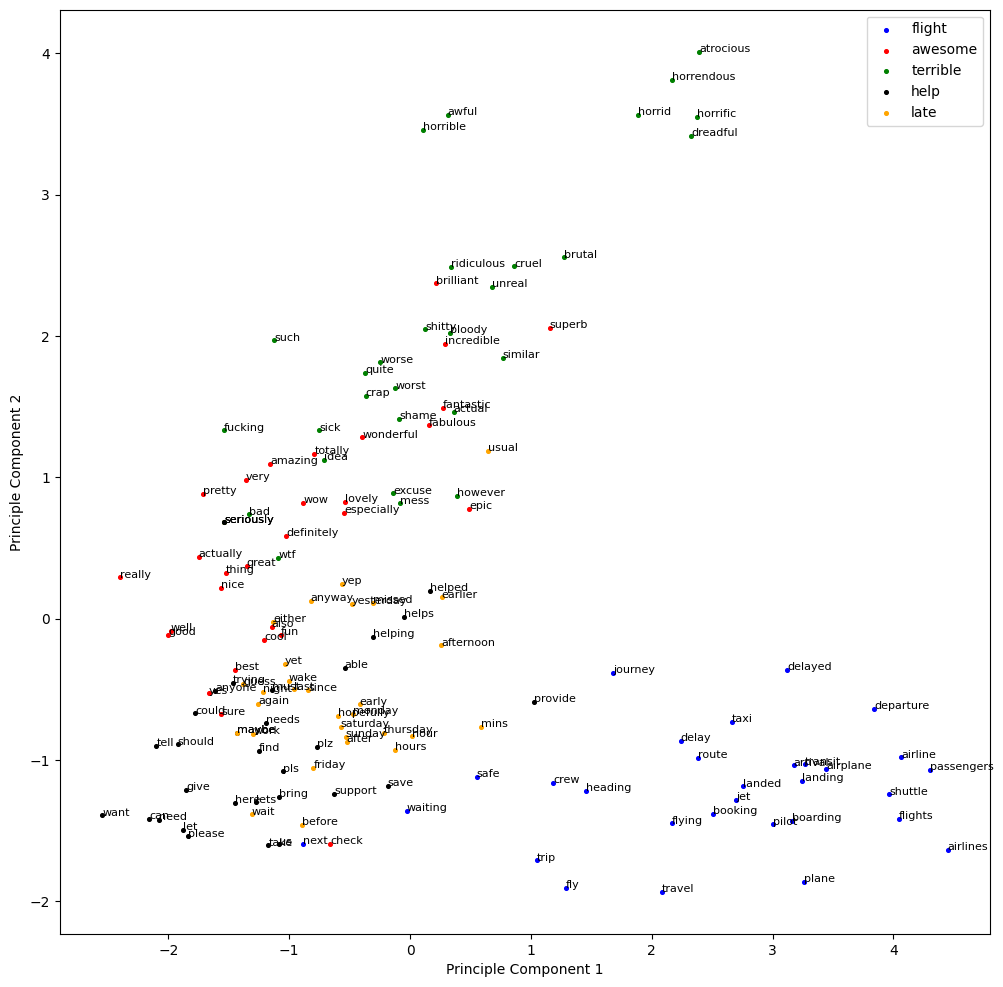

In [ ]:
# Your code goes here.

# Instantiate the PCA model
pca              = PCA(n_components=2)  # Specify the number of components you want to keep
dim_reduced_comp = {}

# Fit the model and transform the data
all_data = np.concatenate([collected_data['embeddings'][seed_word] for seed_word in collected_data['embeddings']]) # Concatenate all the seed words and its similar words
pca.fit(all_data)

for seed_word in collected_data['embeddings']:
  # print(seed_word)
  dim_reduced_comp[seed_word] = np.array(pca.transform(collected_data['embeddings'][seed_word])) # Reduce dimension of embedding vector (200) using PCA to 2D

color = ['blue', 'red', 'green', 'black', 'orange']                                              # Select five different color for different seed words

fig = plt.figure(figsize=(12,12))
for ind, seed_word in enumerate(dim_reduced_comp):
  x , y = dim_reduced_comp[seed_word][:,0], dim_reduced_comp[seed_word][:,1]                     # X principle component-1 and y principle component-2

  # Plot the words in 2D space
  plt.scatter(x, y, color=color[ind], s=7, label=seed_word)

  # Annotate each of the words
  for i, sim_word in enumerate(df[seed_word]):
    plt.annotate(sim_word, (x[i], y[i]), size =8)


plt.legend()
plt.title('')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.show()


**Question**
Do you see five distinct clusters in the 2-d visualization produced by PCA? Please comment on the separation or lack thereof you observe from the visualization.



**Your answer goes here:**
We see four distinct clusters. The blue cluster is on the bottom right. An orange or black cluster is on the bottom left. A red cluster is on the center left. And a green cluser at the top. Most of the clusters have good separation, but the cluster on the bottom left has a noticeable lack of separation between orange and black data points.


### 1.2.2. t-SNE (20pts)

Next you will apply a nonlinear embedding method t-SNE (you can use sklearn.manifold.TSNE with Euclidean distance) to reduce the dimension of the 150 words to 2-d and visualize them using the same color mapping. Note that Perplexity is a critical parameter for t-SNE. It is recommended by the authors of t-SNE that the perplexity value should be between 5 and 50. For this assignment, please consider different perplexity values including 5, 10, 20, 30, 40, and 50.

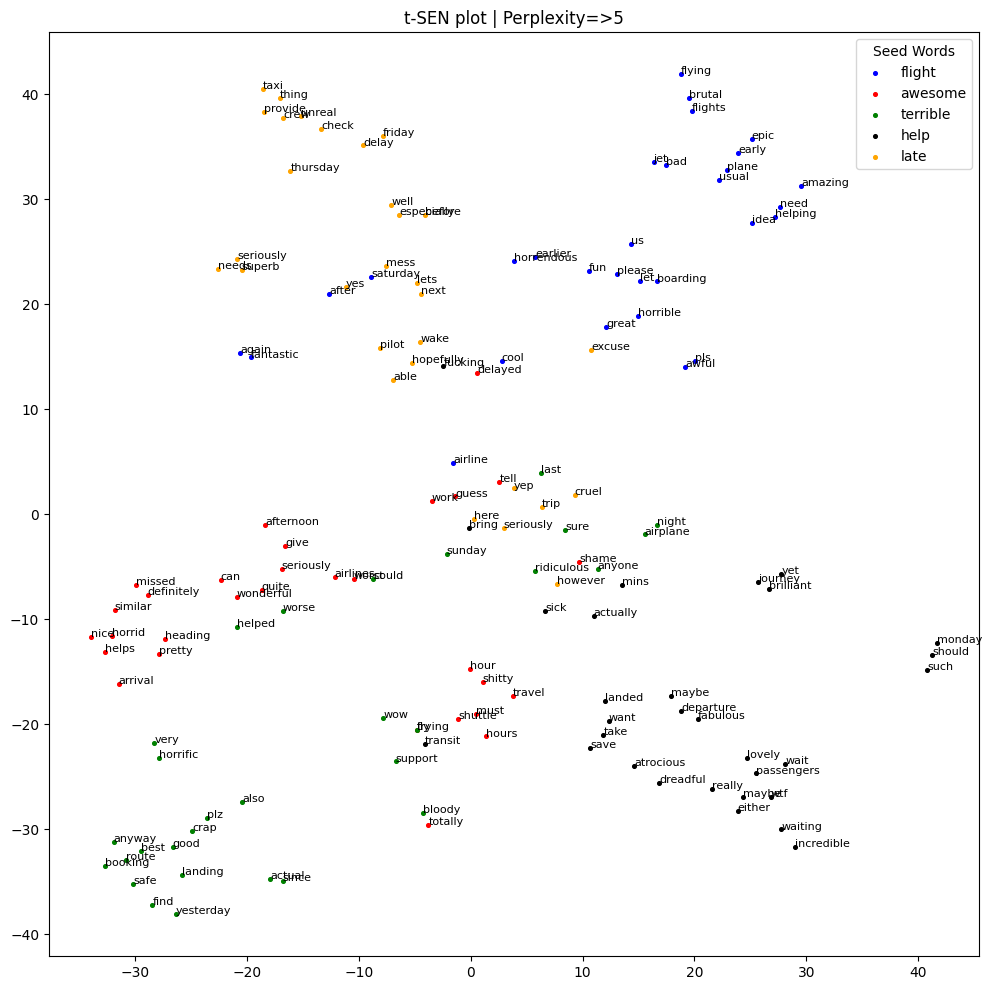

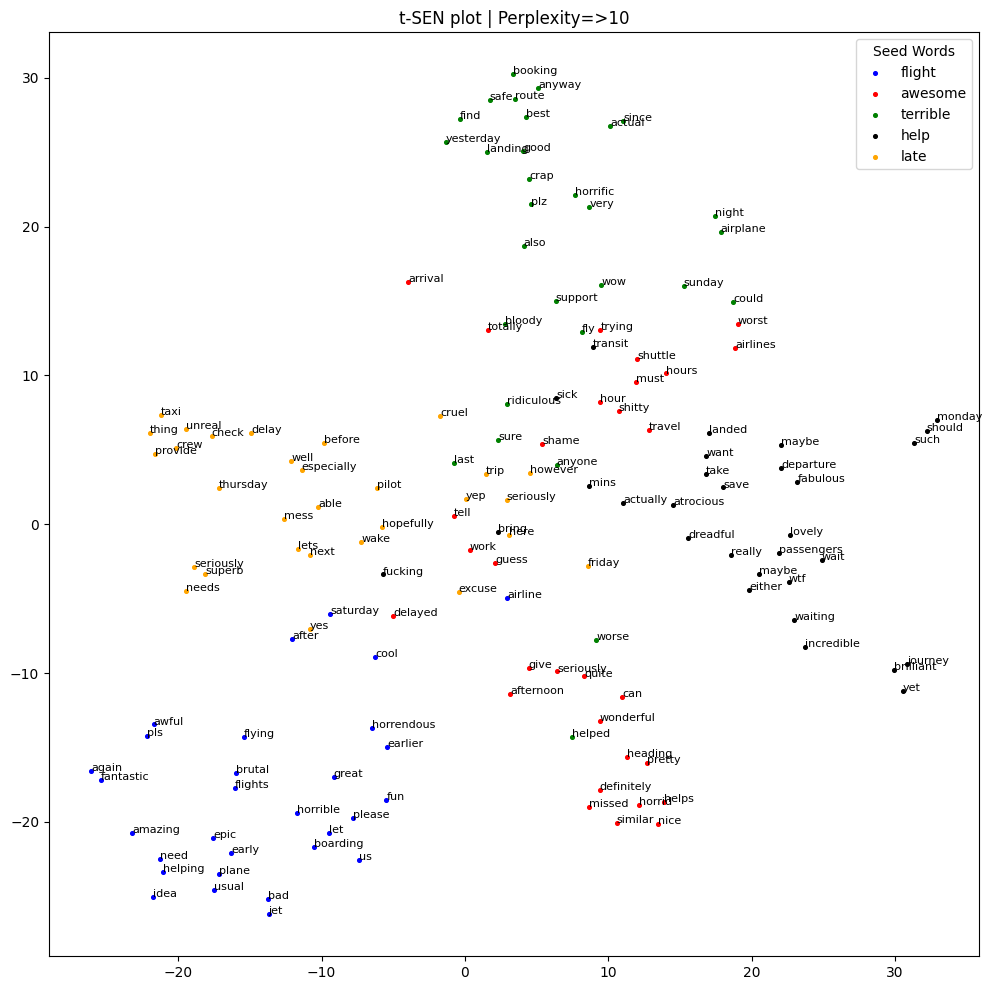

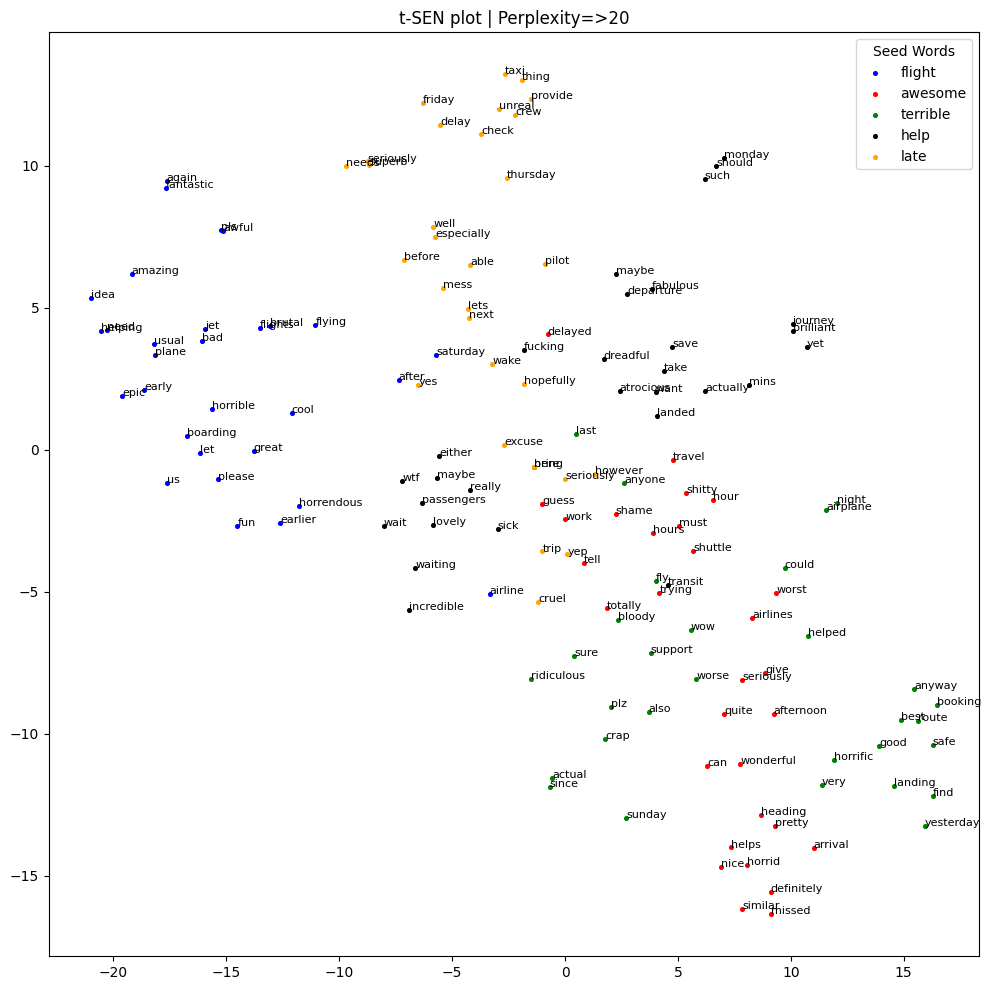

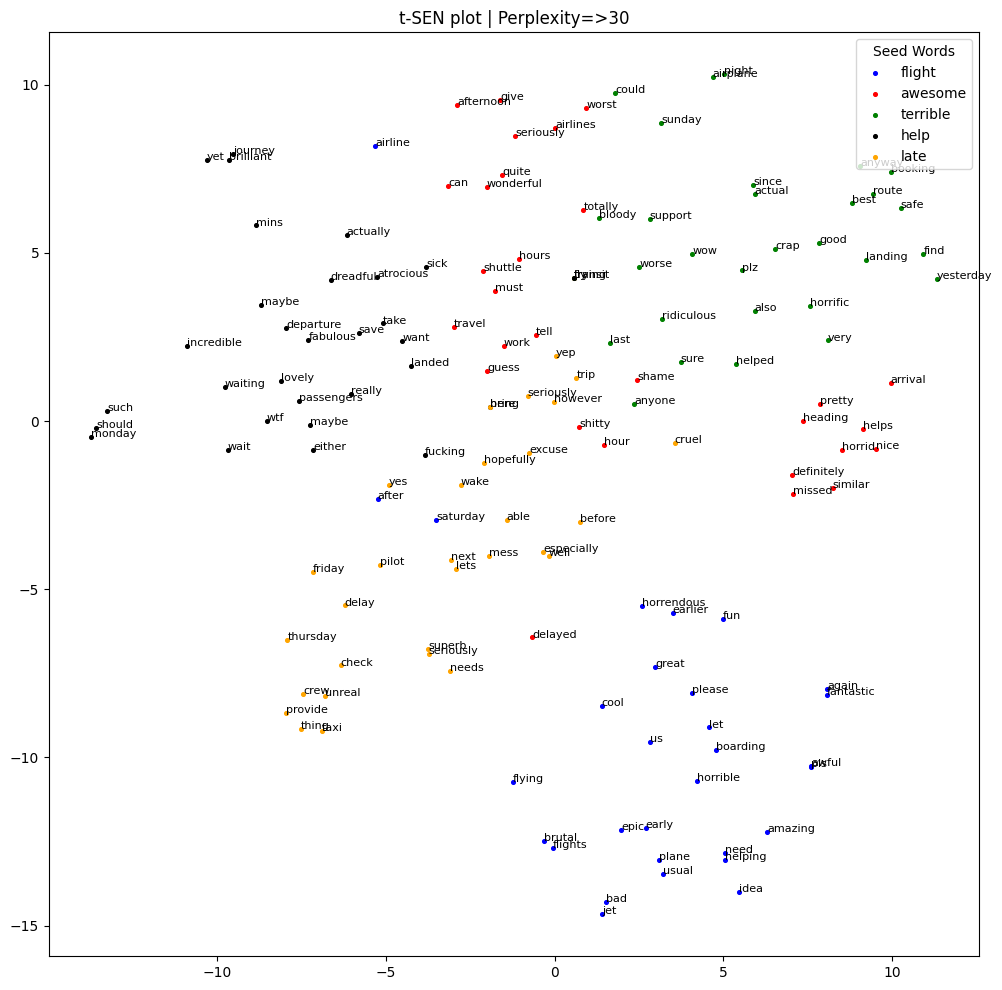

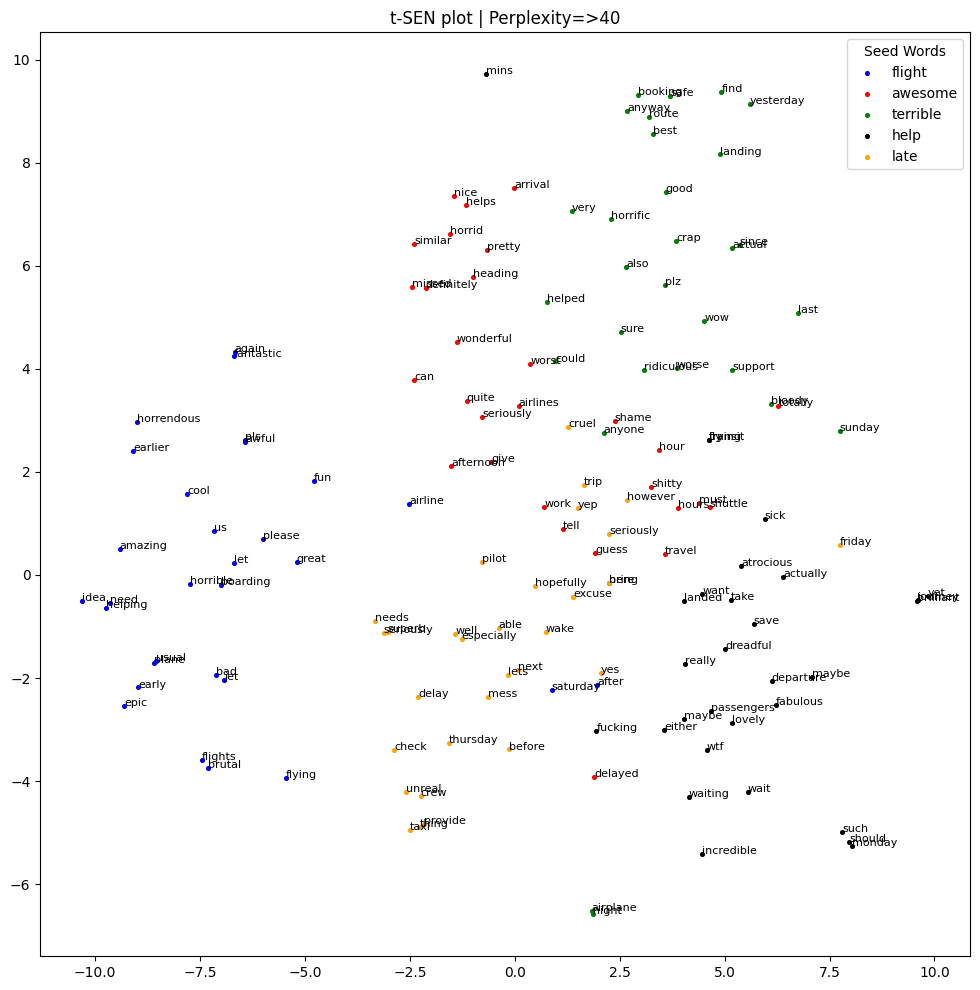

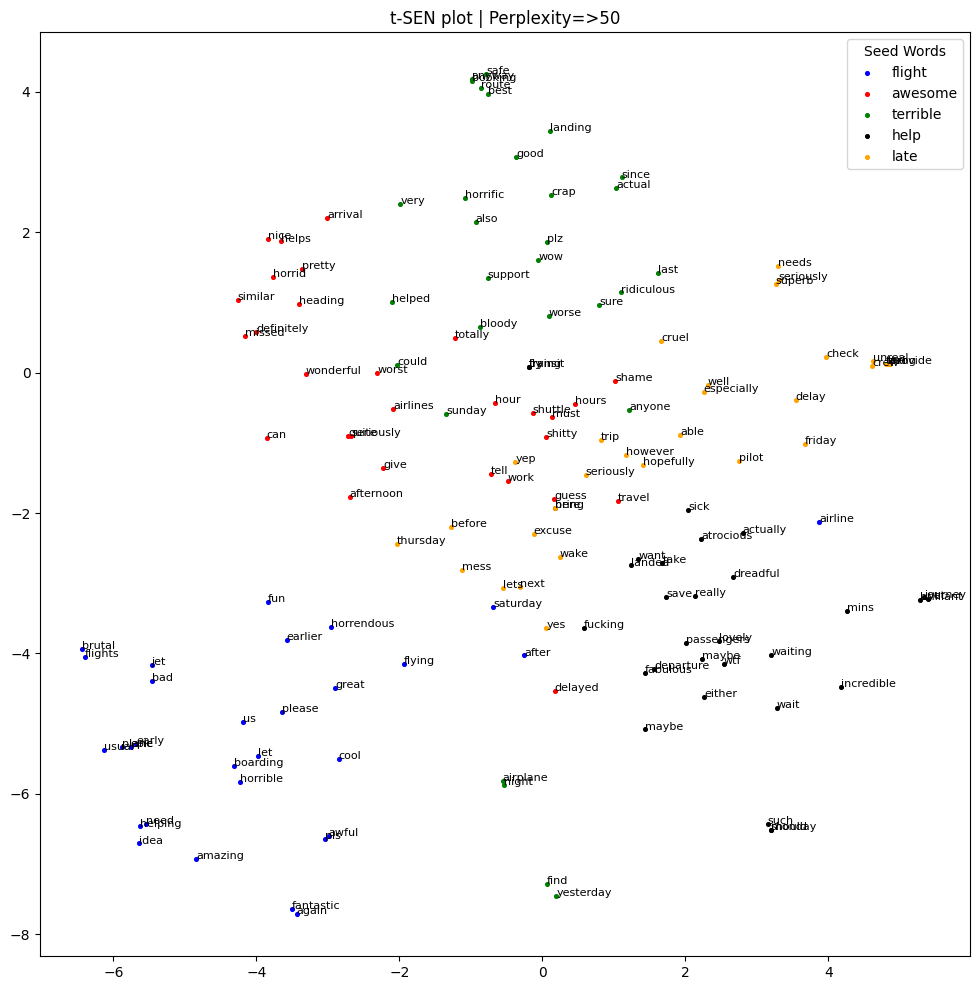

In [ ]:
# Your code goes here
n_components   = 2
PERPLEXITIES   = [5, 10, 20, 30, 40, 50]

all_words_name = np.concatenate(df.values).tolist()

for perplexity in PERPLEXITIES:
  legend_handles = {}
  tsne         = TSNE(n_components=n_components, perplexity=perplexity, random_state=42).fit_transform(all_data)
  color        = ['blue', 'red', 'green', 'black', 'orange']                                         # Select five different color for different seed words

  fig = plt.figure(figsize=(12,12))
  for ind, output in enumerate(tsne):

    if ind % 30 == 0:
      c         = color[int(ind/30)]
      seed_word = seed_words[int(ind/30)]

    x, y  = output                     # X principle component-1 and y principle component-2

     # Plot the words in 2D space with labels for the legend
    if ind % 30 == 0 and seed_word not in legend_handles:
        scatter = plt.scatter(x, y, color=c, s=7, label=seed_word)
        legend_handles[seed_word] = scatter
    else:
        plt.scatter(x, y, color=c, s=7)

    # Annotate each of the words
    plt.annotate(all_words_name[ind], (x, y), size =8)

  plt.title(f't-SEN plot | Perplexity=>{perplexity}')
  plt.legend(handles=list(legend_handles.values()), title="Seed Words",loc='upper right')
  plt.show()

**Question**
Do you see distinct clusters in the 2-d visualizations produced by t-SNE? Please comment on the separation or lack thereof that you observe from the visualization for different perplexity value. How does the perplexity parameter influence the results?

Yes, the clusters are distinct by t-SNE.

 **Your answe goes here.**
 Yes, the clusters are distinct by t-SNE. Based on seed words 'flight', 'awesome', 'terrible', 'help', and 'late', each has associated words clustered around them. However, some clusters appear to have clear boundaries, while others are less distinct and have some overlap.

Perplexity=5: The clusters are quite spread out with clear gaps between them.
Perplexity=10: As the perplexity increases, the clusters start to move closer together.
Perplexity=20, 30, 40: The clusters are closer and begin to overlap slightly. With even higher perplexity values, the clusters become denser and more central, showing increased mixing."

When the perplexity is lower, there is a greater seperation between the center of the clusters is large, and this decreases as perplexity increases untill the clusers overlap.

## 1.3 Clustering the words (35pts)

### 1.3.1. Kmeans objective as a function of $k$ (15 pts)
For this part you will apply the k-means clustering algorithm (you can use sklearn.cluster.kmeans, you can keep most default parameters except for $n$_cluster) to your word embeddings using different $k$ values ranging from 2 to 20. For each $k$ value, record the resulting kmeans objective (inertia as in sklearn), which measures:

$$
\sum_{i=1}^k\sum_{x\in C_i} \|x - \mu_i\|^2
$$

Plot the kmeans objective as a function of $k$.



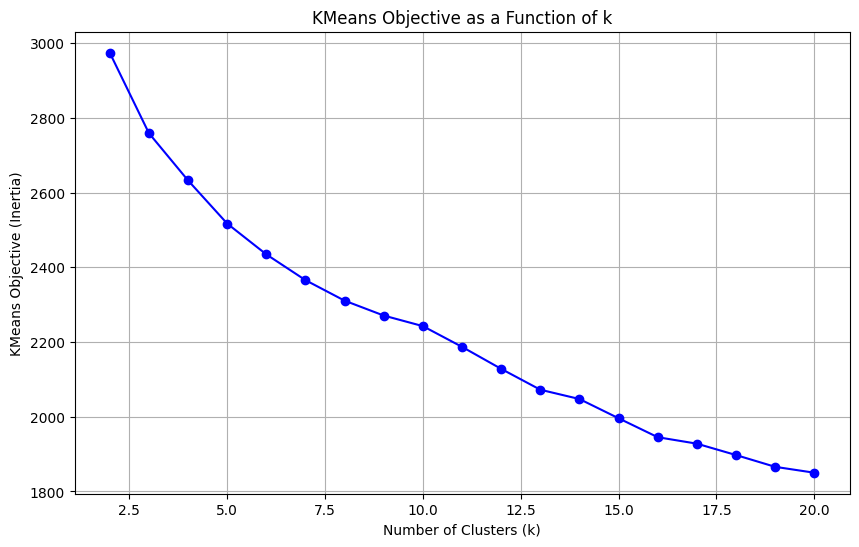

In [ ]:
# Your code goes here
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Function to calculate kmeans objective (inertia) for a given k
def calculate_kmeans_objective(embeddings, k):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(embeddings)
    return kmeans.inertia_

# Range of k values from 2 to 20
k_values = range(2, 21)

# Calculate kmeans objective for each k value
inertia_values = [calculate_kmeans_objective(all_data, k) for k in k_values]

# Plot the kmeans objective as a function of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.title('KMeans Objective as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('KMeans Objective (Inertia)')
plt.grid(True)
plt.show()

**Question:**
Do you observe monotonically decreasing objective value as we increase $k$? Do you see any evidence from this curve that suggests $k=5$?  Provide an explanation for your observations.

**Your answer goes here.**
Yes, the objective seems to be monotonically decreasing as k increases. I do not see evidence that k=5 is a good solution. I do not see the expected elbow or knee at k=5. There is evidence that the optimal value would be k=10 as there is a elbow present at that value. It could be that the dataset is not seperatable enough for 5 clusers.


###1.3.2 Evaluation metrics (20 pts)
Using the original seed word as ground truth labels for clustering, please evaluate the clustering solution for different $k$ values using different metrics including:

- Purity (you will need to implement this measure.)
- Adjusted rand index (you can use sklearn.metrics.adjusted\_rand\_score) and
- Normalized Mutual Information (you can use sklearn.metrics.normalized\_mutual\_info\_score).


Plot each metric you get as a function of $k$.




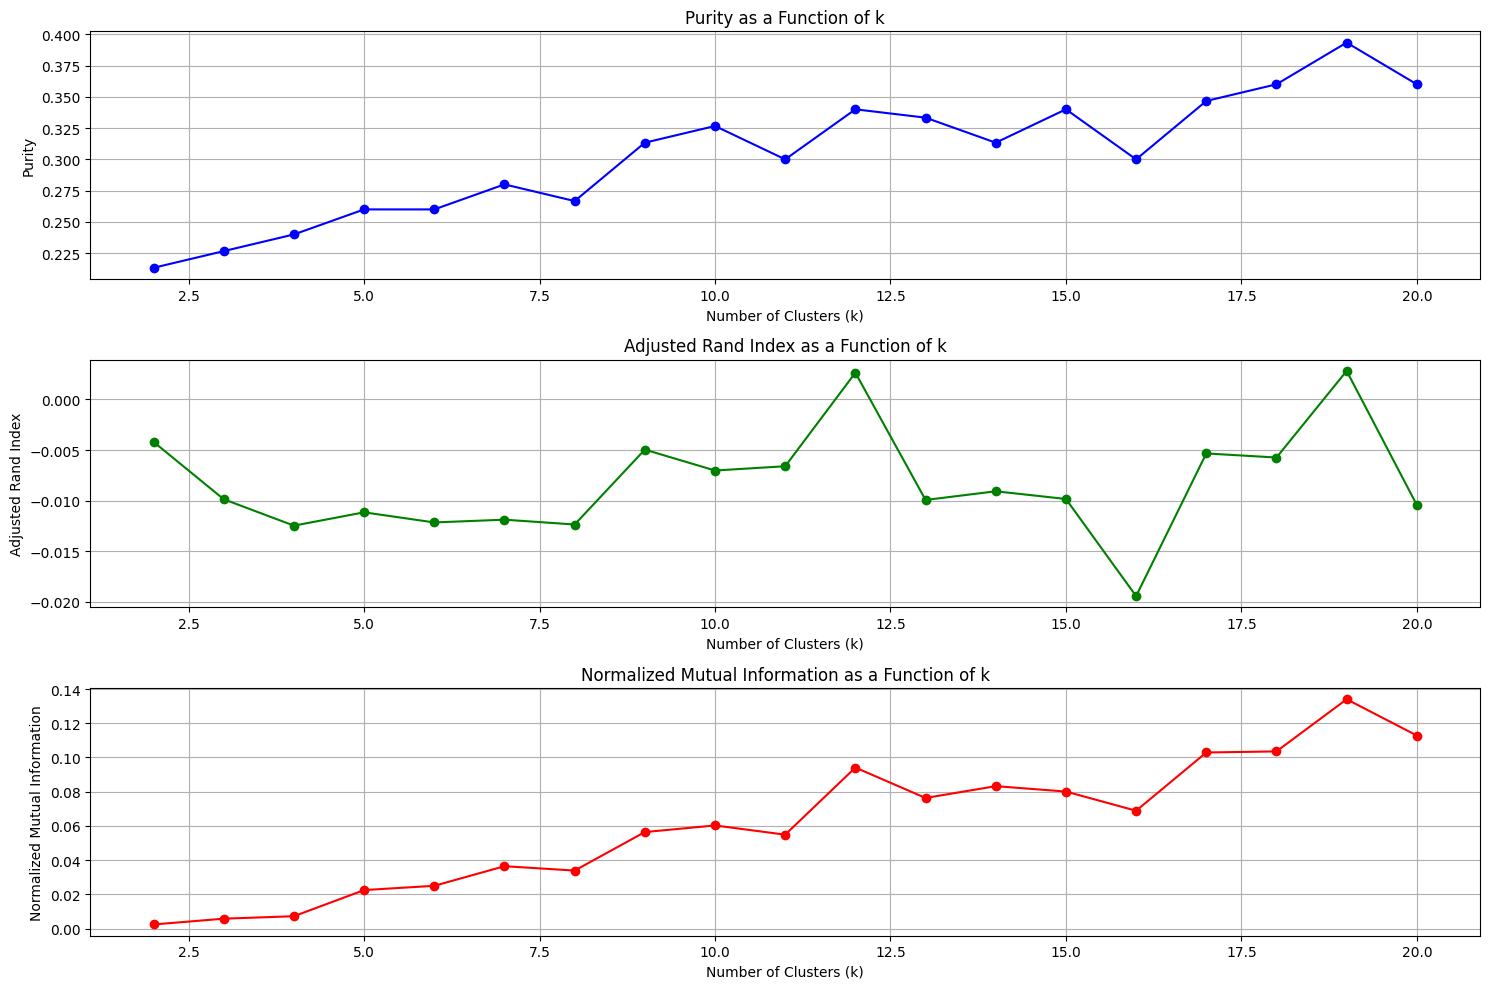

In [ ]:
# Your code goes here.
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
# original seed words
true_labels = ['flight', 'awesome', 'terrible', 'help', 'late'] * 30

# Calculate evaluation metrics for each k value
purity_values = []
adjusted_rand_values = []
normalized_mutual_info_values = []

def calculate_purity(labels, true_labels):
    contingency_matrix = pd.crosstab(labels, true_labels)
    max_in_contingency = contingency_matrix.max(axis=0)
    return max_in_contingency.sum() / len(labels)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(all_data)
    pred_labels = kmeans.labels_

    # Calculate Purity
    purity = calculate_purity(true_labels, pred_labels)
    purity_values.append(purity)

    # Calculate Adjusted Rand Index
    adjusted_rand = adjusted_rand_score(true_labels, pred_labels)
    adjusted_rand_values.append(adjusted_rand)

    # Calculate Normalized Mutual Information
    normalized_mutual_info = normalized_mutual_info_score(true_labels, pred_labels)
    normalized_mutual_info_values.append(normalized_mutual_info)

# Plot each metric as a function of k
plt.figure(figsize=(15, 10))

# Purity plot
plt.subplot(3, 1, 1)
plt.plot(k_values, purity_values, marker='o', linestyle='-', color='b')
plt.title('Purity as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Purity')
plt.grid(True)

# Adjusted Rand Index plot
plt.subplot(3, 1, 2)
plt.plot(k_values, adjusted_rand_values, marker='o', linestyle='-', color='g')
plt.title('Adjusted Rand Index as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index')
plt.grid(True)

# Normalized Mutual Information plot
plt.subplot(3, 1, 3)
plt.plot(k_values, normalized_mutual_info_values, marker='o', linestyle='-', color='r')
plt.title('Normalized Mutual Information as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Normalized Mutual Information')
plt.grid(True)

plt.tight_layout()
plt.show()


**Question:**
1. Does $k=5$ give the best score for different metrics? Provide an explanation for your observation. 2. Which of these three metrics are appropriate to use if we are evaluating two different clustering algorithms that automatically search for the number of clusters in the data (that is, one algorithm might find five clusters in the data while the other might find ten)?

**Your answer goes here.**
k=5 does not give the highest score for any metric, but it does see some local increases in score for each of the 3 metrics. The best score for all 3 metrics happens at k=19. This is expected as metrics like purity and adjusted rand index are sensitive to the number of clusters and we would expect to see higher scores with increasing values of k as the model begins to overfit.

Normalized Mutual information would likely be most appropriate for comparing two different algoritms that seach for an optimal number of clusters as it takes into account the uncertainty in the number of clusters and normalizes the output.

# Part 2 (Optional): Using word embeddings to improve classification (25 Bonus pts)


For this bonus part, you will work with the sentiment classification dataset used in IA3 and conduct a somewhat open ended exploration to answer the following question:

How can you improve the bag-of-words representation for classification using the word embeddings?

Note that we are not looking for deep-learning based approaches. Rather, I am inviting you to think creatively about using the classifiers that we learned in this class so far but try to also leverage the word embeddings to improve the representation for the tweets so that the classification performance can be improved.

Here are some basic ideas to get you started.  

1. A tweet is a collecion of words. Instead of using BoW representation like we did in IA3, we can take the weighted average of the embeddings of the words in the tweet as a representation for the tweet. The embedding of a word can be weighted by the (normalized) tf-idf value for that word. This will greatly reduce the dimension of the tweet compared to the BoW representation, which can potentially reduce overfitting.

2. In BoW representation, we have the issue that words of similar meaning are treated as completely distinct. To see why this is a problem, consider "good trip" and "pleasant journey", they mean the same thing but in BoW representation they have nothing in common.  One possible way to address this is to group words in the vocabulary into clusters (e.g., "good" and "pleasant" will be in the same cluster whereas "trip" and "journey" will be in the same
cluster), and use Bag-of-word-clusters representation. In this case, the two phrases will have identical representation. This will substantially reduce the dimension and redundancy of the features.

You can pick one of these ideas, or try some of your own ideas. For classifier, you can experiment with any classifiers that have been covered in this class.  You only need to focus on one core idea in your exploration to get the bonus points. Also you are not required to get improved performance compared to IA3.  In addtion to provide the code for your exploration, you will also need to provide a brief report that clearly
*   describes your idea (and any hyperparameters/variants you have explored around that idea),
*   discusses the results (the training and validation performances),  
*   provides your interpretation of the results (e.g., how does your method influence the model's ability/tendency to overfit or underfit compared to the standard BoW method).  

In [ ]:
# Your code goes here
import pandas as pd
import string
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.metrics import accuracy_score
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer

drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA3-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path   = '/content/gdrive/My Drive/AI534/IA3-dev.csv'   # DO NOT MODIFY THIS. Please make sure your data has this exact path

train_data = pd.read_csv(train_path)
val_data   = pd.read_csv(val_path)

def text_preprocessing(x):
  remove_char         = str.maketrans("", "", string.punctuation)
  remove_pun_char     = x.translate(remove_char).split(' ')
  return [word.lower() for word in remove_pun_char if word not in stopwords.words('english')]

# Your code goes here
tweets_train  = train_data['text'].apply(lambda x: ' '.join(text_preprocessing(x))).values.tolist()     # Converting all the training tweets into list
tweets_val    = val_data['text'].apply(lambda x: ' '.join(text_preprocessing(x))).values.tolist()       # Converting all the valiation tweets into list

vectorizer    = TfidfVectorizer(stop_words='english')  # Creating instance
X_train       = vectorizer.fit_transform(tweets_train) # Creating tf-idf for the training documents

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Your code goes here
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans

glove      = GloVe_Embedder(EMBEDDING_PATH)
all_voc    = list(vectorizer.vocabulary_)

all_vec    = []
all_labels = []

# Find the Vector Embedding
for word in tqdm(all_voc):
  vec = glove.embedding_dict[word]
  all_vec.append(vec)                       # Collect all the vector embeddings
  all_labels.append(word)                   # Collect all the words
  assert vec.shape[0]==200                  # Check if all the words has valid vector array

100%|██████████| 10748/10748 [00:00<00:00, 371212.19it/s]


In [ ]:
# Group similar n=3 words into the cluster
n = 3
k = len(all_labels)//n
print("Number of clusters:", k)

# Create a KMeans instance
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to the data
kmeans.fit(all_vec)

# Get cluster labels and cluster centers
labels = kmeans.labels_

Number of clusters: 3582


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Assigning new cluster labels to each word
new_voc = {}

for word, label in zip(all_labels, labels):
  new_voc[word] = label                      # Word to cluster label

In [ ]:
import math
from collections import Counter

# Replace the similar word in the document so that the clustered words are counted
def group_the_words(words):
  words = text_preprocessing(words)
  word_index   = []
  temp_unique  = {}

  for word in words:
    try:
      label = new_voc[word.lower()]          # Find the cluster label of the word
    except:
      continue

    word_index.append(label)
    if label not in temp_unique.keys():      # record the word if it's label appered for the first time
      temp_unique[label] = word.lower()      # record the ealiest word to replace other words from the cluster

  return ' '.join([temp_unique[ind] for ind in word_index])   # Replace the all other cluster words with the same word


# Function to calculate Term Frequency (TF)
def calculate_tf(document):
    words       = document.split()
    word_count  = Counter(words)
    total_words = len(words)
    tf          = {word: count / total_words for word, count in word_count.items()}
    return tf

# Function to calculate Inverse Document Frequency (IDF)
def calculate_idf(documents):
    total_documents = len(documents)
    document_frequency = {}

    for document in documents:
        words = set(document.split())
        for word in words:
            document_frequency[word] = document_frequency.get(word, 0) + 1

    idf = {word: math.log((1 + total_documents) / (1 + document_frequency[word])) for word in document_frequency}
    return idf

# Create one hot vector for training the model
def create_one_hot_vector(valid_index, values):
  output = np.zeros((len(set(labels)) + 1))
  output[valid_index.astype(int)] = values       # Store the calculated TF-IDF value in the respective index position
  return output


# Function to calculate TF-IDF matrix
def calculate_tfidf_matrix(documents):
    tf_list = [calculate_tf(doc) for doc in documents]
    idf = calculate_idf(documents)

    tfidf_matrix = []

    for tf in tf_list:
        tfidf_row    = np.array([(new_voc[word], tf[word] * idf[word]) for word in tf if word in new_voc.keys()])
        ttidf_onehot = create_one_hot_vector(tfidf_row[:,0], tfidf_row[:,1])
        tfidf_matrix.append(ttidf_onehot.tolist())

    return tfidf_matrix


In [ ]:
# Remove stop words, puncuations, and group the similar words
preprocess_train = train_data['text'].apply(lambda x: group_the_words(x)).values.tolist()
preprocess_val   = val_data['text'].apply(lambda x: group_the_words(x)).values.tolist()

In [ ]:
tfidf_matrix     = calculate_tfidf_matrix(preprocess_train)   # Calculate the TF-IDF with one hot vector output for word grouping
tfidf_matrix_val = calculate_tfidf_matrix(preprocess_val)     # Calculate the TF-IDF with one hot vector output for word grouping

Y_train          = train_data['sentiment'].values             # Sentiments label from training data
Y_val            = val_data['sentiment'].values               # Sentiments label from validation data

In [ ]:
# With out clustered
matrix_train_no    = calculate_tfidf_matrix(tweets_train)     # Calculate the TF-IDF with one hot vector output for no word grouping
matrix_val_no      = calculate_tfidf_matrix(tweets_val)       # Calculate the TF-IDF with one hot vector output for no word grouping

In [ ]:
# Your code goes here.`
c = 1.8656635785769125

def evaluate_SVM(c, X_train, Y_train, X_val, Y_val, predict_train=True):
  # Building linear SVM
  svm_model = svm.SVC(kernel='linear', C = c)
  svm_model.fit(X_train, Y_train) # Fitting training data for SVM model


  # Predict Validation accuracy
  Y_val_pred   = svm_model.predict(X_val)
  val_acc      = accuracy_score(Y_val, Y_val_pred)

  # Predict Training accuracy
  Y_train_pred   = svm_model.predict(X_train)
  train_acc      = accuracy_score(Y_train, Y_train_pred)

  print("Training Accuracy", train_acc, "val_acc", val_acc)
  # return svm_model, train_acc, val_acc

# Training Accuracy and Validation accuracy when grouping the similar words
evaluate_SVM(c, tfidf_matrix, Y_train, tfidf_matrix_val, Y_val)                                                           # Build SVM Model

Training Accuracy 0.961 val_acc 0.8988


In [ ]:

# Trainin and validation accuracy without grouping the similar words
evaluate_SVM(c, matrix_train_no, Y_train, matrix_val_no, Y_val)

Training Accuracy 0.9567777777777777 val_acc 0.8956


## Our Ideas:<br>
We tried changing the ngrams and tested with Bigram and Trigram; however, it didn't improve the result, so we have implemented a second approach (grouping similar words) as discussed above, which has improved both our training and validation accuracy. <br>

1) We initally fit the TfidfVectorizer with our training data and collected all the vocabularies present in our data.<br>

2) We used GloVe to find the embedding vectors for each word.<br>

3) We used K-Means algorithm to group similar words into a same cluster. We grouped N similar number of words together. Tested N=(5, 10, 20, 30), Number of clusters=(2094, 1047, 523, 349).<br>

4) We labeled each words in the vocabulary with new cluster label.

5) We pre-processed the training data. During pre-processing, we removed punculations, stop words, and lowercased all the words.<br>

6) We replaced the same clustered words in a sentence by a first occuring word from the same cluster.<br>
**For Example:** Suppose the word 'happy' and 'excited' are on same cluster.<br>
Sentence: I am happy today and excited about the weather.<br>
<br>
After pre-processing and replacing the word we get following output:<br>
i am happy today and happy about the weather. <br>
Since 'happy' and 'excited' are on same cluster we just take happy. Now the word 'happy' and 'excited' has similar representation and will be counted twice during the word count in a document.
<br>

7) We tried to change the vocabulary set in **TfidfVectorizer** with our new labels from K-means. However, the internal function gave error. *ValueError: Vocabulary contains repeated indices.* We got this error because **TfidfVectorizer** requies unique index for each words. Since we clustered the words together we need to assign same label to the same group so We have create our own function to create Term Frequency(TF), Inverse Document Frequency (IDF), and TF-IDF matrix.<nr>

8) In Term Frequency we assumed the grouped words as same and they were counted as same word. Similary, we did the same while calculating IDF.<br>

9) After calculating the IF-IDF for a document (sentence), we created one hot vector with the IF-IDF values and trained the SVM model.

## Results for Training and Validation
a. SVM linear results without grouping similar words:<br>
Training Accuracy: 0.9567777777777777  <br>
Validation Accuracy: 0.8944 <br>

b. SVM linear results after grouping similar words (similar words n = 5 | number of cluster: 2094):<br>
Training Accuracy: 0.961 <br>
Validation Accuracy: 0.8988 <br>

c. SVM linear results after grouping similar words (similar words n=10 | number of cluster=1047)<br>
Training Accuracy: 0.9295555555555556<br>
Validation Accuracy: 0.8980 <br>

d. SVM linear results after grouping similar words (similar words n=20 | number of cluster=523)<br>
Training Accuracy: 0.9128888888888889<br>
Validation Accuracy: 0.8964 <br>


## Interpretation of results:
When we grouped five similar words and created 2094 clusters from the vocabulary, both the training accuracy and the validation accuracy increased from 95% to 96.1% (1.1%) and 89.4% to 89.8% (0.4%). Which shows that grouping the similar words provides better features for the model. When we group the similar words, their IF-IDF value increases as more than one word from the same group is present in the sentence. Clustering the smilar group has reduced dimensions from 10470 to only 2094, so the redundant features are removed from the training set, increasing model fit and generalization capabilities. <br>



However, increasing the grouping number (n), i.e., decreasing the number of clusters (k), decreased the performance of the model. Observed training accuracies are 96.1%, 92.9%, and 91.2% for n = 5, 10, and 20, respectively. This shows that when we group a larger number of similar words together, model underfitting increases. This might have happened because there was a loss of information in the data. The uniqueness of each word is lost, which might have underfitted the model. Similary, validation accuracy slightly decreased as we increased the grouping number from n = 5. The observed validation accuracies are 89.88%, 89.80%, and 89.64% for n = 5, 10, and 20, respectively. <br>



Therefore, selecting a number of words in a group (n), i.e., the number of clusters (k), is a hyperparameter that needs to be tuned according to the nature of the data. Selecting the correct value of n will increase the performance of the model in different NLP tasks, such as sentiment analysis.






